In [1]:
import pandas as pd
import numpy as np
import os
import random
import scipy as sp

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

v3.1: removing flights from not major airports

### Load flights data. Can't handle all the data together, so I'm loading a specific number of random lines.
I also load only specific columns sincs I think the other columns are not necessary for what I want to do.
Specifically, I want to predict whether a flight will be late or not. The only potencially useful column which I excluded from my data was day of the month, since extra 31 columns (1 for each day of the month) would be too much for my computer, though I can always implement it later

In [2]:
# total number of datapoints = 5819078 

n = 5819078
#skip = sorted(random.sample(range(1,n),n-2000))
skip = random.sample(range(1,n),n-1000000)
flights = pd.read_csv('flights.csv',skiprows=skip,usecols = ['MONTH','DAY_OF_WEEK','AIRLINE','ORIGIN_AIRPORT','DESTINATION_AIRPORT','SCHEDULED_DEPARTURE',
                                                             'DEPARTURE_DELAY','ARRIVAL_DELAY','CANCELLED'],low_memory=False)
airports = pd.read_csv('airports.csv')
airlines = pd.read_csv('airlines.csv')
flights = flights.sample(frac=1).reset_index(drop=True)  # here I randomize rows so that data is not chronologically sorted

all_features = flights.columns.values
#all_features

## Analysing overall flights data at this point

In [3]:
#flights.info()
#flights.describe()
#flights[(~np.isnan(flights['DEPARTURE_DELAY'])) & (np.isnan(flights['ARRIVAL_DELAY']))]

#for col in airlines:
#    print ("%d NULL values are found in column %s" % (airlines[col].isnull().sum().sum(), col))

#for col in airports:
#    print ("%d NULL values are found in column %s" % (airports[col].isnull().sum().sum(), col))

#for col in flights:
#    print ("%d NULL values are found in column %s" % (flights[col].isnull().sum().sum(), col))

#flights.plot(y=['DEPARTURE_DELAY'])

### fixing airport data
Some of the airports were listed using 5 digit numbers instead of 3 letter code. the code below fixes that problem. I took this code from someone on the internet. Will cite the source

In [4]:
aircode1 = pd.DataFrame.from_csv('L_AIRPORT.csv')
aircode2 = pd.DataFrame.from_csv('L_AIRPORT_ID.csv')

# Format the airport codes
aircode1 = aircode1.reset_index()
aircode2 = aircode2.reset_index()
aircodes = pd.merge(aircode1,aircode2,on='Description')
aircode_dict = dict(zip(aircodes['Code_y'].astype(str),aircodes['Code_x']))

# Make sure all Origin and departing airports are strings
flights['ORIGIN_AIRPORT'] = flights['ORIGIN_AIRPORT'].values.astype(str)
flights['DESTINATION_AIRPORT'] = flights['DESTINATION_AIRPORT'].values.astype(str)

for i in range(len(flights)):
    if len(flights['ORIGIN_AIRPORT'][i]) != 3:
        to_replace = flights['ORIGIN_AIRPORT'][i]
        value = aircode_dict[flights['ORIGIN_AIRPORT'][i]]
        flights = flights.replace(to_replace, value)
for i in range(len(flights)):
    if len(flights['DESTINATION_AIRPORT'][i]) != 3:
        to_replace = flights['DESTINATION_AIRPORT'][i]
        value = aircode_dict[flights['DESTINATION_AIRPORT'][i]]
        flights = flights.replace(to_replace, value)

## Creating a column describing whether the flight was late to arrivelate or got cancelled
Again, for simplicity, I decided to combine these two features. I also chose 60min threshhold arbitrarily

In [5]:
def late_or_cancelled(x):
#    if x['ARRIVAL_DELAY'] > 120:
    if x['CANCELLED'] == 1 or x['ARRIVAL_DELAY'] > 80:
        return 1
    else:
        return 0

flights['late or cancelled'] = flights.apply(late_or_cancelled,axis = 1)
flights = flights[flights['CANCELLED']==0]
#predictions = flights.apply(late_or_cancelled,axis = 1)

## Since departure time is a categorical feature, I will devide it into 4 different sections
I will devide it into 6 hour sections stating with midnight

In [6]:
flights['SCHEDULED_DEPARTURE'] = np.ceil(flights['SCHEDULED_DEPARTURE']/600).apply(int)

## Getting rid of unnecessary data

In [7]:
del flights['ARRIVAL_DELAY']
del flights['DEPARTURE_DELAY']
del flights['CANCELLED']

## Plotting being late or not vs different features

In [8]:
Delay_vs_Day_of_Week = pd.DataFrame({'delays' : flights.groupby(['DAY_OF_WEEK'])['late or cancelled'].mean()}).reset_index()
Delay_vs_MONTH = pd.DataFrame({'delays' : flights.groupby(['MONTH'])['late or cancelled'].mean()}).reset_index()
Delay_vs_AIRLINE = pd.DataFrame({'delays' : flights.groupby(['AIRLINE'])['late or cancelled'].mean()}).reset_index()
Delay_vs_SCHEDULED_DEPARTURE = pd.DataFrame({'delays' : flights.groupby(['SCHEDULED_DEPARTURE'])['late or cancelled'].mean()}).reset_index()

#Delay_vs_Day_of_Week.plot(x='DAY_OF_WEEK', y='delays')
#Delay_vs_Day_of_Week['delays'].hist(hold=None)

<Container object of 3 artists>

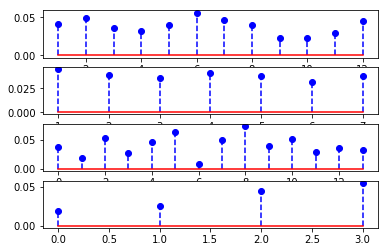

In [9]:
fig, ((a,b,c,d)) = plt.subplots(4,1)
a.stem(Delay_vs_MONTH['MONTH'], Delay_vs_MONTH['delays'], linefmt='b--', markerfmt='bo', basefmt='r-')
b.stem(Delay_vs_Day_of_Week['DAY_OF_WEEK'], Delay_vs_Day_of_Week['delays'], linefmt='b--', markerfmt='bo', basefmt='r-')
c.stem(range(len(Delay_vs_AIRLINE)), Delay_vs_AIRLINE['delays'], linefmt='b--', markerfmt='bo', basefmt='r-')
d.stem(range(len(Delay_vs_SCHEDULED_DEPARTURE)), Delay_vs_SCHEDULED_DEPARTURE['delays'], linefmt='b--', markerfmt='bo', basefmt='r-')

# Removing flights from not major airports
There are too many airports at this point, making it hard to fit the data. I will retain only top 30 airports based on number of flights

In [10]:
max_Airports = 15  # max number of airports to be analyzed
ORIGIN_AIRPORTs = set(flights.groupby(['ORIGIN_AIRPORT'])['late or cancelled'].sum().sort_values(ascending=False)[0:max_Airports].index.tolist())
DESTINATION_AIRPORT = set(flights.groupby(['DESTINATION_AIRPORT'])['late or cancelled'].sum().sort_values(ascending=False)[0:max_Airports].index.tolist())
airports = ORIGIN_AIRPORTs | DESTINATION_AIRPORT

print(flights.shape)

flights = flights[(flights['ORIGIN_AIRPORT'].isin(airports)) & (flights['DESTINATION_AIRPORT'].isin(airports))]

(984480, 7)


## Correcting for a bias in being late vs not being late
Typically, there is much higher number of flights which were not late or cancelled than the ones that were. This creates an imbalance later when trying to classify or fit the data. So I'm getting rid of random rows where the plane was not late.
This way the number of rows where flights['late or cancelled']=1 or not is approximately the same. This should make predictions more accurate.

In [11]:
num_late = sum(flights['late or cancelled'])

flights_on_time = flights[flights['late or cancelled']==0]

flights_on_time = flights_on_time.sample(frac=num_late/flights.shape[0]).reset_index(drop=True)
flights_on_time.shape
flights = pd.concat([flights[flights['late or cancelled']==1],flights_on_time])
flights = flights.sample(frac=1).reset_index(drop=True)

## Converting categorical values to sparce matrixes
At this point, all of the features are categorical, so I need to convert them into sparce matrixes using LabelBinarizer.
I tried to do this using pipelines, but it didn't quite work. Apparently, eventhough fit_transform was working just fine for the pipeline, just fit didn't work. I need just fit alone so that later I can apply it to data for which I'll want to make a prediction.

In [12]:
from sklearn.preprocessing import LabelBinarizer

MONTH_LabBin = LabelBinarizer()
MONTH_LabBin.fit(flights['MONTH'])
MONTH_binarized = np.array(MONTH_LabBin.transform(flights['MONTH']))

DAY_OF_WEEK_LabBin = LabelBinarizer()
DAY_OF_WEEK_LabBin.fit(flights['DAY_OF_WEEK'])
DAY_OF_WEEK_binarized = np.array(DAY_OF_WEEK_LabBin.transform(flights['DAY_OF_WEEK']))

AIRLINE_LabBin = LabelBinarizer()
AIRLINE_LabBin.fit(flights['AIRLINE'])
AIRLINE_binarized = np.array(MONTH_LabBin.transform(flights['AIRLINE']))

ORIGIN_AIRPORT_LabBin = LabelBinarizer()
ORIGIN_AIRPORT_LabBin.fit(flights['ORIGIN_AIRPORT'])
ORIGIN_AIRPORT_binarized = np.array(DAY_OF_WEEK_LabBin.transform(flights['ORIGIN_AIRPORT']))

DESTINATION_AIRPORT_LabBin = LabelBinarizer()
DESTINATION_AIRPORT_LabBin.fit(flights['DESTINATION_AIRPORT'])
DESTINATION_AIRPORT_binarized = np.array(MONTH_LabBin.transform(flights['DESTINATION_AIRPORT']))

SCHEDULED_DEPARTURE_LabBin = LabelBinarizer()
SCHEDULED_DEPARTURE_LabBin.fit(flights['SCHEDULED_DEPARTURE'])
SCHEDULED_DEPARTURE_binarized = np.array(DAY_OF_WEEK_LabBin.transform(flights['SCHEDULED_DEPARTURE']))

# flights_binarized will contain all data in sparce matrix form
flights_binarized = np.concatenate((MONTH_binarized,DAY_OF_WEEK_binarized,AIRLINE_binarized,ORIGIN_AIRPORT_binarized,
                                    DESTINATION_AIRPORT_binarized,SCHEDULED_DEPARTURE_binarized),axis=1)


# split into test and training set

In [13]:
# splitting data into test and training sets
from sklearn.model_selection import train_test_split

train_set, test_set, train_set_target, test_set_target = train_test_split(flights_binarized, flights['late or cancelled'], test_size = 0.2, random_state=42)

# fit data using linear regression
using a primitive model, not expecting any good results

In [14]:
# using simple linear regression
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(train_set,train_set_target)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [15]:
from sklearn.metrics import confusion_matrix
confusion_matrix(train_set_target,(lin_reg.predict(train_set)).round())

array([[3124, 2506],
       [2024, 3926]])

# Ridge Regression

In [16]:
# using ridge regression
# I don't expect this to help much. It should help to avoid overfitting, but I'm clearly underfitting data so it is kind of useless.
from sklearn.linear_model import Ridge
ridge_reg = Ridge(alpha=1, solver="cholesky")
ridge_reg.fit(train_set,train_set_target)

confusion_matrix(train_set_target,(ridge_reg.predict(train_set)).round())

array([[3101, 2529],
       [2004, 3946]])

# SGD Regression (L2)

In [17]:
from sklearn.linear_model import SGDRegressor
sgd_reg = SGDRegressor(penalty="l2")
sgd_reg.fit(train_set,train_set_target)
confusion_matrix(train_set_target,(sgd_reg.predict(train_set)).round())

array([[3134, 2496],
       [2042, 3908]])

# Decision Tree
Decision Tree with default values seems to have worked the best so far, so I will attempt Random forest.

In [18]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(train_set,train_set_target)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best')

In [19]:
confusion_matrix(train_set_target,(tree_reg.predict(train_set)).round())

array([[3240, 2390],
       [1768, 4182]])

In [20]:
from sklearn.model_selection import cross_val_score
#scores = cross_val_score(tree_reg, train_set,train_set_target, scoring = "neg_mean_squared_error", cv=10)

# Random forest search

In [21]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor()
forest_reg.fit(train_set,train_set_target)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [22]:
confusion_matrix(train_set_target,(forest_reg.predict(train_set)).round())

array([[3279, 2351],
       [1815, 4135]])

# GridSearch for RandomForest
Random Forest did the best so far, so I'll try gridsearch to get the best conditions for random forest model

In [23]:
from sklearn.model_selection import GridSearchCV

param_grid = [{'n_estimators': [3,10,30,100],'max_features':[5,10,50]}]
forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(train_set,train_set_target)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'n_estimators': [3, 10, 30, 100], 'max_features': [5, 10, 50]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

In [24]:
# confusion matrix for training set
confusion_matrix(train_set_target,(grid_search.predict(train_set)).round())

array([[3218, 2412],
       [1747, 4203]])

In [25]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=10, max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [26]:
# confusion matrix for test set
confusion_matrix(test_set_target,(grid_search.predict(test_set)).round())

array([[789, 642],
       [506, 959]])

In [31]:
predictions = grid_search.predict(train_set)
grid_reg_results = pd.DataFrame({'True':train_set_target, 'predict':predictions})

In [33]:
#grid_reg_results[grid_reg_results['predict']>0.85]['True'].sum()/grid_reg_results[grid_reg_results['predict']>0.85]['True'].shape[0]

In [34]:
def comparison_col(x):
    # True pos = 1, True neg = 2, False pos = 3, false neg = 4
    if (x['True'] == 1) & (x['predict'] > 0.5):
        return 1
    elif (x['True'] == 0) & (x['predict'] < 0.5):
        return 2
    elif (x['True'] == 0) & (x['predict'] > 0.5):
        return 3
    elif (x['True'] == 1) & (x['predict'] < 0.5):
        return 4

In [36]:
grid_reg_results['Comparison'] = grid_reg_results.apply(comparison_col, axis = 1)


(0, 1)

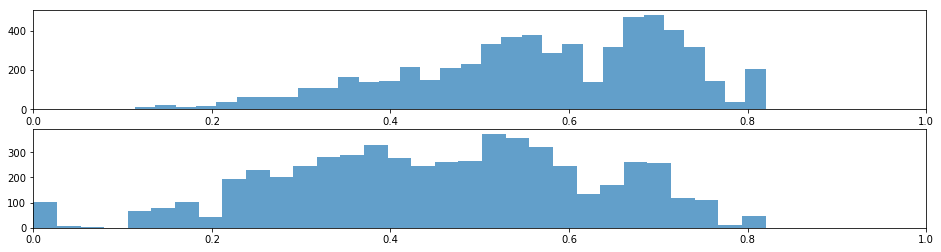

In [38]:
fig, ((a,b)) = plt.subplots(2,1,figsize=(16, 4))
a.hist(grid_reg_results[grid_reg_results['True']==1]['predict'],alpha=0.7, bins=31)
b.hist(grid_reg_results[grid_reg_results['True']==0]['predict'],alpha=0.7, bins=31)
a.set_xlim([0,1])
b.set_xlim([0,1])

# Plotting histograms of my results
Blue color shows correctly predicted results, orange shows incorrect predictions.

(array([   9.,   19.,    9.,   19.,   55.,   51.,   70.,   54.,  146.,
         104.,  138.,  185.,  193.,  161.,  165.,  308.,  189.,  312.,
         407.,  207.,  245.,   99.,  168.,  203.,  274.,  157.,   95.,
          59.,   11.,   47.]),
 array([ 0.11404755,  0.13758381,  0.16112008,  0.18465634,  0.20819261,
         0.23172888,  0.25526514,  0.27880141,  0.30233767,  0.32587394,
         0.34941021,  0.37294647,  0.39648274,  0.420019  ,  0.44355527,
         0.46709154,  0.4906278 ,  0.51416407,  0.53770033,  0.5612366 ,
         0.58477287,  0.60830913,  0.6318454 ,  0.65538166,  0.67891793,
         0.7024542 ,  0.72599046,  0.74952673,  0.77306299,  0.79659926,
         0.82013553]),
 <a list of 30 Patch objects>)

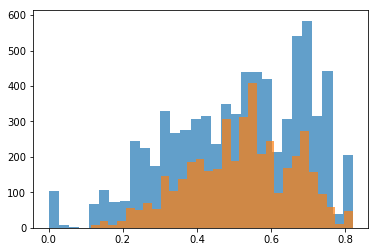

In [39]:
plt.hist(grid_reg_results[grid_reg_results['Comparison'].isin([1,2])]['predict'],alpha=0.7, bins=30)
plt.hist(grid_reg_results[grid_reg_results['Comparison'].isin([3,4])]['predict'],alpha=0.7, bins=30)

In [40]:
test_predictions = tree_reg.predict(test_set)
test_forest_reg_results = pd.DataFrame({'True':test_set_target, 'predict':test_predictions})
test_forest_reg_results['Comparison'] = test_forest_reg_results.apply(comparison_col, axis = 1)


(array([  13.,    0.,    0.,    0.,    5.,    9.,    5.,    7.,   38.,
          23.,   15.,   31.,   36.,   47.,   58.,   54.,   58.,   75.,
          44.,   80.,  108.,   63.,   50.,   43.,   69.,   72.,   51.,
          37.,    2.,   14.]),
 array([ 0.        ,  0.02745098,  0.05490196,  0.08235294,  0.10980392,
         0.1372549 ,  0.16470588,  0.19215686,  0.21960784,  0.24705882,
         0.2745098 ,  0.30196078,  0.32941176,  0.35686275,  0.38431373,
         0.41176471,  0.43921569,  0.46666667,  0.49411765,  0.52156863,
         0.54901961,  0.57647059,  0.60392157,  0.63137255,  0.65882353,
         0.68627451,  0.71372549,  0.74117647,  0.76862745,  0.79607843,
         0.82352941]),
 <a list of 30 Patch objects>)

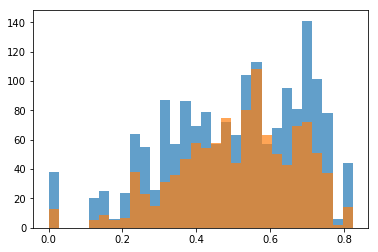

In [41]:
plt.hist(test_forest_reg_results[test_forest_reg_results['Comparison'].isin([1,2])]['predict'],alpha=0.7, bins=30)
plt.hist(test_forest_reg_results[test_forest_reg_results['Comparison'].isin([3,4])]['predict'],alpha=0.7, bins=30)